In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv")
df.total_bedrooms = df.total_bedrooms.fillna(0)

In [3]:
df = df[(df.ocean_proximity == "<1H OCEAN") | (df.ocean_proximity == "INLAND")]

In [4]:
#@ SPLITTING THE DATASET FOR TRAINING AND TEST:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [5]:
#@ INITIALIZING TRAINING FEATURES:
features = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
               "median_income", "ocean_proximity"]
train_dicts = df_train[features].to_dict(orient='records')
val_dicts = df_val[features].to_dict(orient='records')

In [6]:
#@ IMPLEMENTATION OF DICTVECTORIZER:
dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [7]:
#@ TRAINING THE REGRESSION MODEL:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [8]:
#@ INSPECTION:
print(export_text(dt, feature_names=dv.feature_names_))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]


In [9]:
print("Q1 = ocean_proximity")

Q1 = ocean_proximity


In [10]:
#@ TRAINING RANDOM FOREST MODEL:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [11]:
#@ CALCULATING MEAN SQUARED ERROR:
y_pred = rf.predict(X_val)
x = np.sqrt(mean_squared_error(y_val, y_pred))

print(f"Q2 = {x}")

Q2 = 0.24527740463893766


In [12]:
#@ TRAINING THE RANDOM FOREST MODEL:
scores = []

for n in tqdm(range(10, 201, 10)):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    
    scores.append((n, score))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

  0%|          | 0/20 [00:00<?, ?it/s]

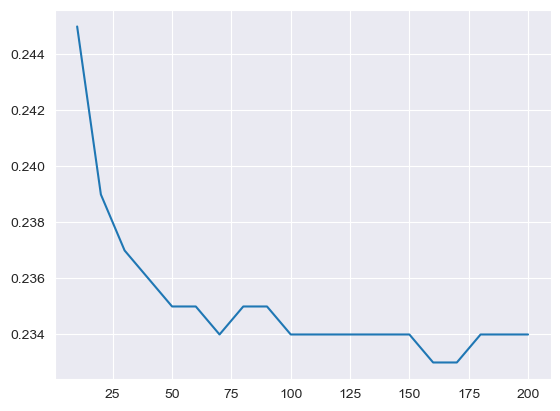

In [13]:
#@ INSPECTING THE RMSE SCORES:
plt.plot(df_scores.n_estimators, df_scores.rmse.round(3))
plt.show()

In [14]:
print("Q3 = 160")

Q3 = 160


In [15]:
#@ TRAINING THE MODEL WITH DEPTH:
scores = []

for d in tqdm([10, 15, 20, 25]):
    rf = RandomForestRegressor(n_estimators=0,
                               max_depth=d,
                               random_state=1, n_jobs=-1,
                               warm_start=True)

    for n in tqdm(range(10, 201, 10)):
        rf.n_estimators = n
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))

        scores.append((d, n, score))

columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

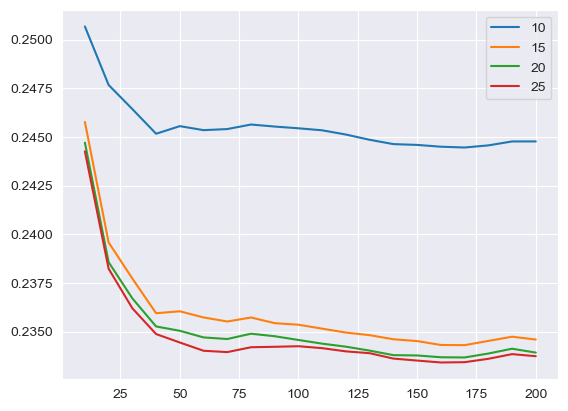

In [16]:
#@ PLOTTING THE GRAPH:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=d)

plt.legend()
plt.show()

In [17]:
print("Q4 = 25")

Q4 = 25


In [18]:
#@ TRAINING THE RANDOM FOREST MODEL:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, 
                           random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [19]:
#@ INSPECTING FEATURE IMPORTANCE:
rf.feature_importances_

array([0.0151361 , 0.03031726, 0.10200703, 0.08624381, 0.33561113,
       0.29247297, 0.07380644, 0.02713606, 0.01585222, 0.02141699])

In [20]:
#@ INSPECTING FEATURE IMPORTANCES:
df_importances = pd.DataFrame()
df_importances['feature'] = dv.feature_names_
df_importances['importance'] = rf.feature_importances_
df_importances

,feature,importance
0,households,0.015
1,housing_median_age,0.030
2,latitude,0.102
3,longitude,0.086
4,median_income,0.336
5,ocean_proximity=<1H OCEAN,0.292
6,ocean_proximity=INLAND,0.074
7,population,0.027
8,total_bedrooms,0.016
9,total_rooms,0.021


In [21]:
#@ SORTING THE VALUES:
df_importances.sort_values(by='importance', ascending=False).head()

,feature,importance
4,median_income,0.336
5,ocean_proximity=<1H OCEAN,0.292
2,latitude,0.102
3,longitude,0.086
6,ocean_proximity=INLAND,0.074


In [22]:
print("Q5 = median_income")

Q5 = median_income


In [23]:
#@ CREATING THE DMARTIX:
import re

features = dv.feature_names_

regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [24]:
#@ INITIALIZATION:
watchlist = [(dtrain, 'train'), (dval, 'val')]
scores = {}

In [25]:
#@ DEFINING THE FUNCTION:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [26]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [27]:
#@ STORING:
scores['eta=0.3'] = parse_xgb_output(output)

In [28]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [29]:
#@ STORING:
scores['eta=0.1'] = parse_xgb_output(output)

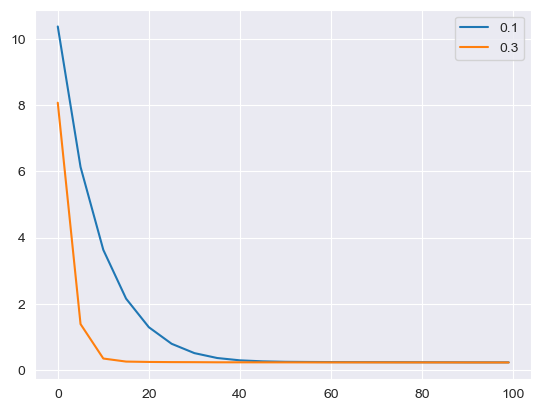

In [30]:
#@ INSPECTION:
plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].val_auc,
        label='0.1')
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val_auc,
        label='0.3')
plt.legend()
plt.show()

In [31]:
print("Q6 = Both give equal value.")

Q6 = Both give equal value.
